<a href="https://colab.research.google.com/github/kapamawi/AI/blob/main/3_3_5___planer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install -qU langgraph langchain langchain-openai

Ten kod instaluje trzy pakiety Pythona:

`langgraph` - narzędzie do tworzenia grafów przepływu danych dla aplikacji AI

`langchain` - framework do budowania aplikacji wykorzystujących modele językowe

`langchain-openai` - integracja OpenAI z LangChain

Instalacja odbywa się przez pip z opcjami:
- `-q` wycisza komunikaty podczas instalacji
- `-U` aktualizuje pakiety do najnowszych wersji, jeśli są już zainstalowane

In [ ]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
import os
from google.colab import userdata


Ten kod importuje niezbędne moduły i klasy do stworzenia grafu konwersacji:

`os` - operacje na systemie plików

`TypedDict, Annotated, List` - typy danych do typowania statycznego

`StateGraph, END` z langgraph - budowa grafu stanów i znacznik końca

`HumanMessage, AIMessage` - klasy wiadomości do konwersacji

`ChatPromptTemplate` - szablony promptów dla modelu

`ChatOpenAI` - integracja z modelami OpenAI

`MermaidDrawMethod` - wizualizacja grafu w formacie Mermaid

`display, Image` - wyświetlanie grafiki w notatniku

`userdata` - dostęp do danych użytkownika w Google Colab

In [ ]:
class CFG:
    model = 'gpt-4o-mini'
    temp = 0.3

os.environ["OPENAI_API_KEY"] = userdata.get('openaivision')

Ten fragment definiuje konfigurację i ustawia klucz API:

Klasa `CFG` zawiera parametry:
- `model` - wybór modelu 'gpt-4o-mini'
- `temp` - temperatura 0.3 (niższa wartość = bardziej przewidywalne odpowiedzi)

Następnie kod ustawia klucz API OpenAI pobrany z danych użytkownika Google Colab.

# Agent

In [ ]:
llm = ChatOpenAI(model = CFG.model)


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

Ten kod tworzy narzędzia do generowania planów podróży:

Tworzy instancję modelu ChatOpenAI z ustawioną konfiguracją.

Definiuje szablon promptu który:
- Ustawia rolę asystenta podróży
- Przyjmuje zmienne {city} oraz {interests}
- Ma generować punktowy plan wycieczki

In [ ]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

Klasa `PlannerState` definiuje strukturę danych dla planera podróży zawierającą:
- `messages` - lista wiadomości (od człowieka i AI)
- `city` - nazwa miasta
- `interests` - lista zainteresowań
- `itinerary` - wygenerowany plan wycieczki

Użyto `TypedDict` do statycznego typowania pól.

In [ ]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip:")
    user_message = input("Your input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

Ta funkcja obsługuje wprowadzanie miasta:

- Wyświetla prośbę o podanie miasta
- Pobiera dane wejściowe od użytkownika
- Aktualizuje stan dodając nazwę miasta i nową wiadomość od użytkownika
- Używa rozwinięcia słownika `**state` do zachowania pozostałych danych stanu

In [ ]:
def input_interests(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(',')],
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

Funkcja zbiera zainteresowania użytkownika:
- Prosi o wpisanie zainteresowań oddzielonych przecinkami
- Przetwarza tekst na listę, usuwając białe znaki
- Aktualizuje stan o listę zainteresowań i nową wiadomość
- Zachowuje pozostałe dane stanu przez `**state`

In [ ]:
def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}...")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

Funkcja tworzy szczegółowy plan wycieczki:
- Informuje o tworzeniu planu dla wybranego miasta i zainteresowań
- Używa LLM do wygenerowania planu na podstawie szablonu promptu
- Wyświetla gotowy plan
- Aktualizuje stan o wygenerowany plan i odpowiedź AI

# Graf

In [ ]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

Ten kod tworzy i konfiguruje strukturę przepływu danych:

1. `workflow = StateGraph(PlannerState)` - inicjalizacja grafu ze zdefiniowanym stanem

2. Dodawanie węzłów z odpowiadającymi funkcjami:
   ```python
   workflow.add_node("input_city", input_city)
   workflow.add_node("input_interests", input_interests)
   workflow.add_node("create_itinerary", create_itinerary)
   ```

3. `workflow.set_entry_point("input_city")` - ustawienie początkowego węzła

4. Definiowanie połączeń między węzłami:
   ```python
   workflow.add_edge("input_city", "input_interests")
   workflow.add_edge("input_interests", "create_itinerary")
   workflow.add_edge("create_itinerary", END)
   ```

5. `app = workflow.compile()` - finalizacja grafu do postaci wykonywalnej aplikacji

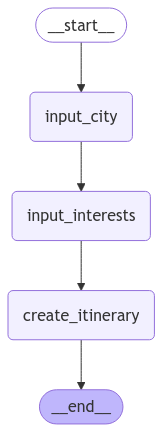

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Ten kod wizualizuje stworzony wcześniej graf:

1. Pobiera strukturę grafu metodą `get_graph()`
2. Generuje obraz w formacie PNG używając notacji Mermaid
3. Przekształca go w obiekt `Image`
4. Wyświetla diagram w notebooku za pomocą funkcji `display()`

Pozwala to zobaczyć graficzną reprezentację przepływu danych między węzłami aplikacji.

In [ ]:
def run_travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    for output in app.stream(state):
        pass  # The nodes themselves now handle all printing

Ta funkcja uruchamia planer podróży:

1. Przyjmuje początkowe zapytanie użytkownika i wyświetla je

2. Tworzy stan początkowy ze słownikiem zawierającym:
   - wiadomość od użytkownika
   - puste miasto
   - pustą listę zainteresowań
   - pusty plan podróży

3. Uruchamia aplikację metodą `stream()` na utworzonym stanie

4. Pomija wyniki pośrednie (`pass`), ponieważ węzły same obsługują wyświetlanie informacji

# Test

In [ ]:

user_request = "I want to plan a day trip."
run_travel_planner(user_request)

Initial Request: I want to plan a day trip.

Please enter the city you want to visit for your day trip:
Your input: Warsaw
Please enter your interests for the trip to Warsaw (comma-separated):
Your input: Cuisine
Creating an itinerary for Warsaw based on interests: Cuisine...

Final Itinerary:
### Day Trip Itinerary: Culinary Delights in Warsaw

**Morning: Traditional Polish Breakfast**
- **9:00 AM - 10:00 AM:** Breakfast at **Cafe Bristol**  
  - Enjoy traditional Polish dishes like **jajecznica** (scrambled eggs) with homemade bread and **kawa** (coffee).

**Mid-Morning: Food Market Exploration**
- **10:30 AM - 12:00 PM:** Visit **Hala Mirowska**  
  - Explore this vibrant market featuring local produce, meats, and cheeses. Sample some local delicacies like **pierogi** (dumplings) and **bigos** (hunter's stew).

**Lunch: Iconic Polish Cuisine**
- **12:30 PM - 1:30 PM:** Lunch at **Zapiecek**  
  - Indulge in a variety of **pierogi** fillings, both savory and sweet, served with sour c